In [1]:
from CrimeTransmissionFunctions import redDelitoDirigida, cargar_agebs, asignar_nombres_agebs, crear_matriz_adyacencia_agebs, monte_carlo_simulaciones_agebs, procesar_simulacion, procesar_simulaciones, matriz_a_grafo, contar_superaciones, calcular_significancia, obtener_matriz_significativa, calcular_inflow_outflow, comparar_simulaciones, colorear_nodos_por_significancia,graficar_grafo_coloreado_y_agebs 

In [2]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import unicodedata
import re
import matplotlib.colors as mcolors

In [3]:
def main(delta_t, delta_s, gdf_Delito, n_simulaciones, gdf_agebs, crimen):

    print("\n" + "-" * 60)
    print("STARTING CRIMINAL NETWORK ANALYSIS")
    print("-" * 60)

    gdf_Delito = gdf_Delito.sort_values(by=['FechaComision'])

    # --- 1. Observed network ---
    print("\n[1] Creation of observed directed network")
    try:
        G = redDelitoDirigida(gdf_Delito, delta_t, delta_s)
        print(f"Directed network of observed data successfully created.")
    except Exception as e:
        print(f"Error creating directed network of observed data: {e}")

    # --- 2. Adjacency matrix ---
    print("\n[2] Calculating transition matrix")
    try:
        nodos_agebs, agebs_nombres = asignar_nombres_agebs(gdf_agebs, G)
        matriz_adyacencia = crear_matriz_adyacencia_agebs(G, nodos_agebs, agebs_nombres)
        print(f"Transition matrix of observed data successfully created.")
    except Exception as e:
        print(f"Error calculating transition matrix of observed data: {e}")

    # --- 3. Monte Carlo simulations ---
    print("\n[3] Monte Carlo simulations")
    try:
        simulaciones = monte_carlo_simulaciones_agebs(gdf_Delito, gdf_agebs, n_simulaciones)
        matriz_promedio, lista_matrices = procesar_simulaciones(simulaciones, gdf_agebs, delta_t, delta_s)
        print(f"Simulations successfully created.")
    except Exception as e:
        print(f"Error generating or processing simulations: {e}")
        
    # --- 4. Significance via Monte Carlo ---
    print("\n[4] Calculating spatial significance")
    try:
        conteos, total = contar_superaciones(matriz_adyacencia, lista_matrices)
        significancia, p_valores = calcular_significancia(conteos, total)
        matriz_conteo_sig = obtener_matriz_significativa(significancia, agebs_nombres)
        s = np.sum(significancia)
        print(f"Simulation significance successfully calculated.")
        print(f"Significant crime pairs: {s}")
    except Exception as e:
        print(f"Error calculating simulation significance: {e}")

     # --- 5. Final graph with inflow/outflow coloring ---
    print("\n[5] Creation and visualization of significant network")
    try: 
        G_significativos = matriz_a_grafo(matriz_conteo_sig, gdf_agebs)
        conteo_inflow_outflow, significativos_inflow_outflow, p_valores_inflow_outflow = comparar_simulaciones(lista_matrices, matriz_adyacencia, agebs_nombres)
        G_final = colorear_nodos_por_significancia(G_significativos, significativos_inflow_outflow)
        print(f"Graph and visualization successfully generated.")
        graficar_grafo_coloreado_y_agebs(G_final, gdf_agebs, crimen, datos = "significant data")
    except Exception as e:
        print(f"Error creating or visualizing the final graph: {e}")

    print("\n" + "-" * 60)
    print("ANALYSIS SUCCESSFULLY COMPLETED")
    print("-" * 60 + "\n")
    
    return G_final, matriz_adyacencia, significancia, p_valores, significativos_inflow_outflow, p_valores_inflow_outflow, agebs_nombres

In [4]:
def guardar_resultados_txt(matriz_adyacencia_obs, significancia_sim, p_valores_sim,
                           significativos_inflow_outflow, p_valores_inflow_outflow,
                           agebs_nombres, carpeta, crimen_id):

    os.makedirs(carpeta, exist_ok=True)  

    # Save main matrices
    np.savetxt(f"{carpeta}/{crimen_id}_adjacency_matrix_obs.txt", matriz_adyacencia_obs, fmt='%d')
    np.savetxt(f"{carpeta}/{crimen_id}_significance_sim.txt", significancia_sim.astype(int), fmt='%d')  # True/False a 1/0
    np.savetxt(f"{carpeta}/{crimen_id}_pvalues_sim.txt", p_valores_sim, fmt='%.6f')

    # Unpack inflow/outflow arrays
    inflow_bool, outflow_bool = significativos_inflow_outflow
    inflow_pval, outflow_pval = p_valores_inflow_outflow

    # Convert booleans to 0 and 1
    inflow_bin = inflow_bool.astype(int)
    outflow_bin = outflow_bool.astype(int)

    # Save inflow/outflow significance
    np.savetxt(f"{carpeta}/{crimen_id}_significance_inflow.txt", inflow_bin, fmt='%d')
    np.savetxt(f"{carpeta}/{crimen_id}_significance_outflow.txt", outflow_bin, fmt='%d')

    # Save p-values inflow/outflow
    np.savetxt(f"{carpeta}/{crimen_id}_pvalues_inflow.txt", inflow_pval, fmt='%.6f')
    np.savetxt(f"{carpeta}/{crimen_id}_pvalues_outflow.txt", outflow_pval, fmt='%.6f')

    # Save AGEB names dictionary
    with open(f"{carpeta}/{crimen_id}_agebs_nombres.txt", "w") as f:
        for key, value in agebs_nombres.items():
            f.write(f"{key}: {value}\n")

    print(f"All files have been successfully saved in the folder '{carpeta}'.")

In [5]:
def dia_noche_separacion(gdf, hora_dia_inicio, hora_dia_fin):
    es_dia = gdf['FechaComision'].dt.hour.between(hora_dia_inicio, hora_dia_fin - 1, inclusive="both")
    gdf_dia = gdf[es_dia].sort_values(by=['FechaComision'])

    es_noche = ~es_dia 
    gdf_noche = gdf[es_noche].sort_values(by=['FechaComision'])

    return gdf_dia, gdf_noche

In [6]:
gdf_agebs = cargar_agebs('conjunto de datos/16a.shp')

In [7]:
# Time and space thresholds
delta_t = 7  # days
delta_s = 500  # meters

# Residential burglary

## General

In [8]:
gdf = gpd.read_file("RoboCasa2017-2024.geojson")
gdf

,CarpetaID,FechaInicio,FechaComision,Fiscalia,Municipio,Colonia,CalleNumero,Lugar,Latitud,Longitud,Delito,Arma,Violencia,geometry
0,70181,2017-01-02 12:20:00,2017-01-01 12:40:00,Morelia,Morelia,Enrique Ramírez,Pedro Sosa número 61,Casa habitación,19.706969,-101.166196,Robo a casa habitación,NaN,SI,POINT (272946.147 2180502.865)
1,70050,2017-01-02 16:00:00,2017-01-02 20:00:00,Morelia,Morelia,Centro Histórico,PRIMERO DE MAYO,Casa habitación,19.707004,-101.185375,Robo a casa habitación,NaN,SI,POINT (270935.159 2180532.505)
2,70265,2017-01-04 12:29:00,2017-01-04 12:30:00,Morelia,Morelia,Ventura Puente,VASCO DE QUIROGA NUM. 1170,Casa habitación,19.691563,-101.190020,Robo a casa habitación,NaN,SI,POINT (270426.060 2178829.164)
3,70577,2017-01-04 15:08:00,2017-01-04 11:00:00,Morelia,Morelia,Centro Histórico,PRIMERA PRIVADA DE BUCARELI NUMERO 52,Departamento,19.703466,-101.179260,Robo a casa habitación,NaN,NO,POINT (271571.330 2180132.543)
4,70256,2017-01-04 16:05:00,2017-01-04 10:30:00,Morelia,Morelia,El Realito,CASTILLO CENTENO NUM. 7,Casa habitación,19.731202,-101.203549,Robo a casa habitación,NaN,SI,POINT (269064.268 2183236.337)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782,470097,2024-08-28 18:45:00,2024-08-28 11:00:00,Morelia,Morelia,Coíntzio,"CARRETERA MORELIA - PATZCUARO, NUMERO 1230, CO...",Salón de fiesta,19.645249,-101.249566,Robo a casa habitación,Desconocida,SI,POINT (264113.718 2173782.727)
4783,470036,2024-08-29 11:49:00,2024-08-27 04:00:00,Morelia,Morelia,San Pedro Chicácuaro,SAN PEDRO CHICACUARO,Casa habitación,19.784572,-101.358604,Robo a casa habitación,Con Alguna Parte del Cuerpo,NO,POINT (252889.629 2189364.604)
4784,469946,2024-08-29 12:32:00,2024-08-23 12:00:00,Morelia,Morelia,Vista Bella,IGNACIO MANUEL ALTAMIRANO,Casa habitación,19.677425,-101.194385,Robo a casa habitación,Otro Elemento,NO,POINT (269948.090 2177269.698)
4785,469982,2024-08-29 17:08:00,2024-07-24 12:00:00,Morelia,Morelia,Torreón Nuevo,PALMA,Casa habitación,19.732486,-101.198786,Robo a casa habitación,Otro Elemento,NO,POINT (269565.509 2183372.000)



------------------------------------------------------------
STARTING CRIMINAL NETWORK ANALYSIS
------------------------------------------------------------

[1] Creation of observed directed network
Number of connected nodes: 1041
Number of edges: 662
Directed network of observed data successfully created.

[2] Calculating transition matrix
Transition matrix of observed data successfully created.

[3] Monte Carlo simulations
Simulations successfully created.

[4] Calculating spatial significance
Simulation significance successfully calculated.
Significant crime pairs: 113

[5] Creation and visualization of significant network
Graph and visualization successfully generated.


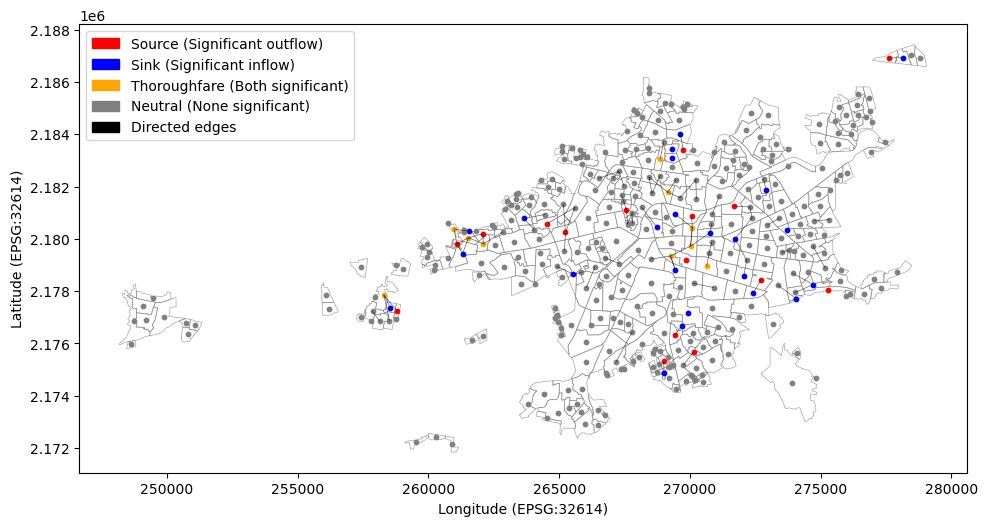


------------------------------------------------------------
ANALYSIS SUCCESSFULLY COMPLETED
------------------------------------------------------------



In [9]:
G_final, matriz_adyacencia_obs, significancia_sim, p_valores_sim, significativos_inflow_outflow, p_valores_inflow_outflow, agebs_nombres = main(delta_t, delta_s, gdf, 99, gdf_agebs, crimen = "residential burglary")

In [10]:
guardar_resultados_txt(matriz_adyacencia_obs, significancia_sim, p_valores_sim, significativos_inflow_outflow, p_valores_inflow_outflow, agebs_nombres, carpeta="ResidentialBurglary", crimen_id = "ResidentialBurglary_Gen")

All files have been successfully saved in the folder 'ResidentialBurglary'.


## Daytime residential burglary

In [11]:
hora_dia_inicio = 7  # 7:00 AM
hora_dia_fin = 19    # 7:00 PM

In [12]:
gdf_robocasa_dia, gdf_robocasa_noche = dia_noche_separacion(gdf, hora_dia_inicio, hora_dia_fin)

In [13]:
gdf_robocasa_dia

,CarpetaID,FechaInicio,FechaComision,Fiscalia,Municipio,Colonia,CalleNumero,Lugar,Latitud,Longitud,Delito,Arma,Violencia,geometry
12,70681,2017-01-08 08:19:00,2017-01-01 08:19:00,Morelia,Morelia,Centro Histórico,primera privada de bucareli,Departamento,19.703506,-101.179233,Robo a casa habitación,NaN,NO,POINT (271574.218 2180136.936)
0,70181,2017-01-02 12:20:00,2017-01-01 12:40:00,Morelia,Morelia,Enrique Ramírez,Pedro Sosa número 61,Casa habitación,19.706969,-101.166196,Robo a casa habitación,NaN,SI,POINT (272946.147 2180502.865)
5,70258,2017-01-04 18:34:00,2017-01-02 16:30:00,Morelia,Morelia,Centro Histórico,CONSTITUCION DE 1917 NUM. 55,Vecindad,19.706229,-101.187910,Robo a casa habitación,NaN,SI,POINT (270668.241 2180450.120)
11,70259,2017-01-06 19:29:00,2017-01-03 08:00:00,Morelia,Morelia,Cruz del Barreno,emilio madrigal 176,Casa habitación,19.722778,-101.208329,Robo a casa habitación,Arma de Fuego,NO,POINT (268550.983 2182310.144)
4,70256,2017-01-04 16:05:00,2017-01-04 10:30:00,Morelia,Morelia,El Realito,CASTILLO CENTENO NUM. 7,Casa habitación,19.731202,-101.203549,Robo a casa habitación,NaN,SI,POINT (269064.268 2183236.337)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,469716,2024-08-26 20:24:00,2024-08-25 11:00:00,Morelia,Morelia,Arcos del Valle,MANUEL OROZCO GOMEZ,Casa habitación,19.706621,-101.232600,Robo a casa habitación,Desconocida,NO,POINT (265982.734 2180554.521)
4779,469574,2024-08-28 11:48:00,2024-08-27 08:00:00,Morelia,Morelia,Villa Magna,villa de santa fe,Casa habitación,19.678165,-101.325029,Robo a casa habitación,Desconocida,NO,POINT (256247.268 2177533.751)
4781,469965,2024-08-28 13:58:00,2024-08-28 10:15:00,Morelia,Morelia,Villa Universidad,PORTUGAL,Casa habitación,19.687637,-101.198306,Robo a casa habitación,Otro Elemento,SI,POINT (269551.498 2178405.709)
4782,470097,2024-08-28 18:45:00,2024-08-28 11:00:00,Morelia,Morelia,Coíntzio,"CARRETERA MORELIA - PATZCUARO, NUMERO 1230, CO...",Salón de fiesta,19.645249,-101.249566,Robo a casa habitación,Desconocida,SI,POINT (264113.718 2173782.727)



------------------------------------------------------------
STARTING CRIMINAL NETWORK ANALYSIS
------------------------------------------------------------

[1] Creation of observed directed network
Number of connected nodes: 523
Number of edges: 308
Directed network of observed data successfully created.

[2] Calculating transition matrix
Transition matrix of observed data successfully created.

[3] Monte Carlo simulations
Simulations successfully created.

[4] Calculating spatial significance
Simulation significance successfully calculated.
Significant crime pairs: 79

[5] Creation and visualization of significant network
Graph and visualization successfully generated.


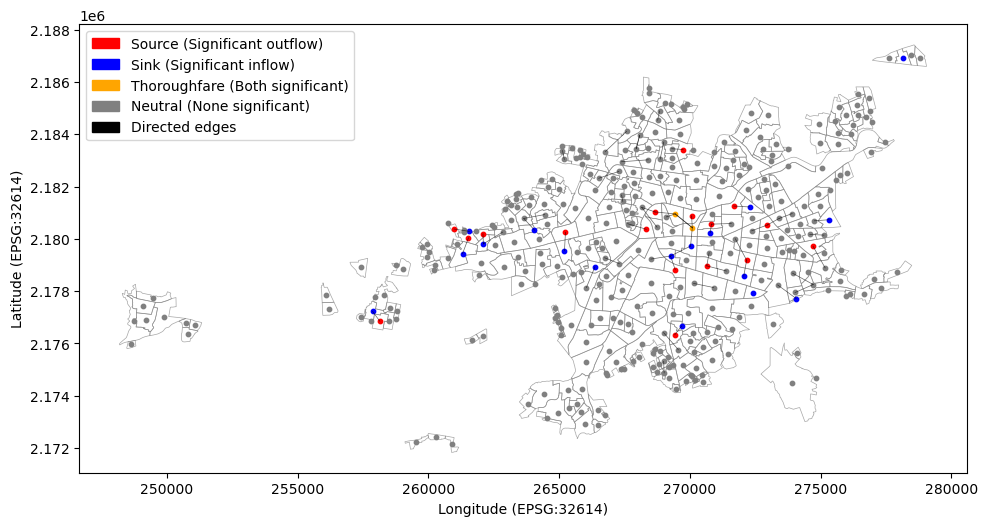


------------------------------------------------------------
ANALYSIS SUCCESSFULLY COMPLETED
------------------------------------------------------------



In [14]:
G_final_dia, matriz_adyacencia_obs_dia, significancia_sim_dia, p_valores_sim_dia, significativos_inflow_outflow_dia, p_valores_inflow_outflow_dia, agebs_nombres = main(delta_t, delta_s, gdf_robocasa_dia, 99, gdf_agebs, crimen = "daytime residential burglary")

In [15]:
guardar_resultados_txt(matriz_adyacencia_obs_dia, significancia_sim_dia, p_valores_sim_dia, significativos_inflow_outflow_dia, p_valores_inflow_outflow_dia, agebs_nombres, carpeta="ResidentialBurglary", crimen_id = "ResidentialBurglary_Day")

All files have been successfully saved in the folder 'ResidentialBurglary'.


## Nighttime residential burglary

In [16]:
gdf_robocasa_noche

,CarpetaID,FechaInicio,FechaComision,Fiscalia,Municipio,Colonia,CalleNumero,Lugar,Latitud,Longitud,Delito,Arma,Violencia,geometry
6,70043,2017-01-04 21:48:00,2017-01-02 06:00:00,Morelia,Morelia,Defensores de Puebla,MANUEL BONILLA NUM. 196,Casa habitación,19.711736,-101.237502,Robo a casa habitación,NaN,SI,POINT (265476.122 2181127.619)
1,70050,2017-01-02 16:00:00,2017-01-02 20:00:00,Morelia,Morelia,Centro Histórico,PRIMERO DE MAYO,Casa habitación,19.707004,-101.185375,Robo a casa habitación,NaN,SI,POINT (270935.159 2180532.505)
8,70282,2017-01-05 20:03:00,2017-01-04 22:41:00,Morelia,Morelia,Enrique Ramírez,LIBRAMIENTO ORIENTE NUM. 1613-A,Casa habitación,19.709297,-101.166862,Robo a casa habitación,NaN,SI,POINT (272879.601 2180761.508)
13,70180,2017-01-08 18:47:00,2017-01-06 20:30:00,Morelia,Morelia,La Hacienda,GAVIOTA NUMERO 267,Casa habitación,19.679325,-101.315099,Robo a casa habitación,NaN,SI,POINT (257290.505 2177647.952)
15,70370,2017-01-09 16:20:00,2017-01-07 19:00:00,Morelia,Morelia,ALTOZANO,MONTES PIRINEOS NUMERO 82,Casa habitación,19.663841,-101.166322,Robo a casa habitación,Desconocida,SI,POINT (272872.089 2175728.001)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4776,469406,2024-08-27 10:00:00,2024-08-21 21:00:00,Morelia,Morelia,EX HACIENDA LA HUERTA,circuito jacarandas,Casa habitación,19.666104,-101.236684,Robo a casa habitación,Otro Elemento,NO,POINT (265495.408 2176074.045)
4773,469260,2024-08-26 10:36:00,2024-08-25 03:00:00,Morelia,Morelia,Unión Antorchista,WENCESLAO VICTORIA SOTO,Casa habitación,19.700248,-101.268603,Robo a casa habitación,Otro Elemento,NO,POINT (262197.909 2179898.933)
4777,469724,2024-08-27 12:16:00,2024-08-26 19:00:00,Morelia,Morelia,Villas Oriente,ELENA GARRO,Casa habitación,19.759219,-101.144709,Robo a casa habitación,Desconocida,SI,POINT (275272.297 2186259.266)
4783,470036,2024-08-29 11:49:00,2024-08-27 04:00:00,Morelia,Morelia,San Pedro Chicácuaro,SAN PEDRO CHICACUARO,Casa habitación,19.784572,-101.358604,Robo a casa habitación,Con Alguna Parte del Cuerpo,NO,POINT (252889.629 2189364.604)



------------------------------------------------------------
STARTING CRIMINAL NETWORK ANALYSIS
------------------------------------------------------------

[1] Creation of observed directed network
Number of connected nodes: 136
Number of edges: 73
Directed network of observed data successfully created.

[2] Calculating transition matrix
Transition matrix of observed data successfully created.

[3] Monte Carlo simulations
Simulations successfully created.

[4] Calculating spatial significance
Simulation significance successfully calculated.
Significant crime pairs: 47

[5] Creation and visualization of significant network
Graph and visualization successfully generated.


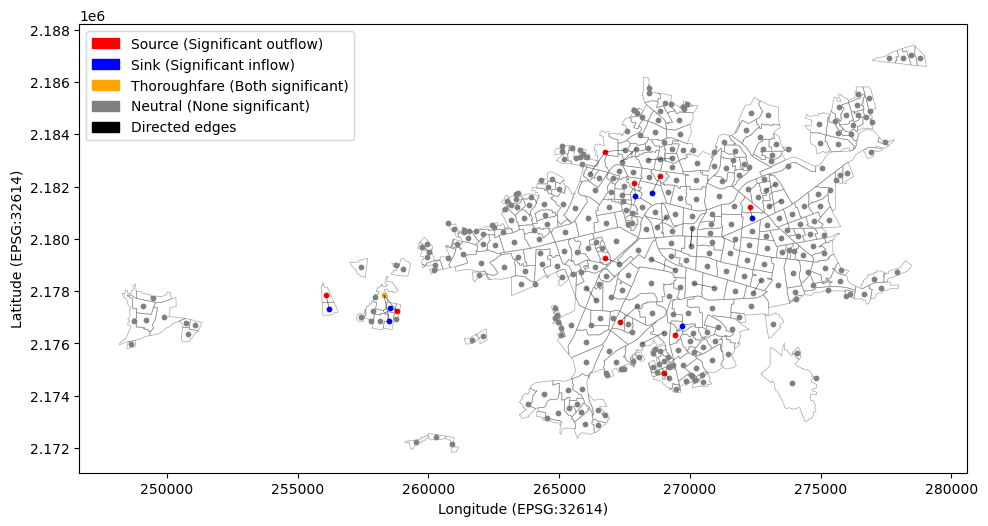


------------------------------------------------------------
ANALYSIS SUCCESSFULLY COMPLETED
------------------------------------------------------------



In [17]:
G_final_noche, matriz_adyacencia_obs_noche, significancia_sim_noche, p_valores_sim_noche, significativos_inflow_outflow_noche, p_valores_inflow_outflow_noche, agebs_nombres = main(delta_t, delta_s, gdf_robocasa_noche, 99, gdf_agebs, crimen = "nighttime residential burglary")

In [18]:
guardar_resultados_txt(matriz_adyacencia_obs_noche, significancia_sim_noche, p_valores_sim_noche, significativos_inflow_outflow_noche, p_valores_inflow_outflow_noche, agebs_nombres, carpeta="ResidentialBurglary", crimen_id = "ResidentialBurglary_Night")

All files have been successfully saved in the folder 'ResidentialBurglary'.


# Commercial robbery

## General

In [19]:
gdf_comercios = gpd.read_file("RoboComercios2017-2024.geojson")
gdf_comercios

,CarpetaID,FechaInicio,FechaComision,Fiscalia,Municipio,Colonia,CalleNumero,Lugar,Latitud,Longitud,Delito,Arma,Violencia,geometry
0,70574,2017-01-03 17:08:00,2017-01-03 17:00:00,Morelia,Morelia,Centenario,MIGUEL HIDALGO Y CASTILLO NUM. 1454,Restaurante,19.733021,-101.173279,Robo a comercios,NaN,NO,POINT (272240.387 2183396.791)
1,70042,2017-01-04 13:36:00,2017-01-04 12:00:00,Morelia,Morelia,Quinceo,PERIFERICO PASEO DE LA REPUBLICA ESQUINA AV. Q...,Comercio,19.724571,-101.223847,Robo a comercios,NaN,SI,POINT (266926.552 2182529.916)
2,70310,2017-01-04 15:25:00,2017-01-04 08:30:00,Morelia,Morelia,Centro Histórico,REVOLUCION NUM. 216,Comercio,19.704821,-101.184099,Robo a comercios,NaN,SI,POINT (271065.848 2180289.085)
3,70261,2017-01-04 17:37:00,2017-01-04 12:40:00,Morelia,Morelia,Francisco J. Múgica,PLAN SEXENAL NUM. 200,Negocio de computadoras,19.725093,-101.189609,Robo a comercios,Arma de Fuego,NO,POINT (270517.029 2182541.026)
4,70418,2017-01-06 20:08:00,2017-01-06 11:00:00,Morelia,Morelia,Lago I,PLAZA COMERCIAL ESTADIO SIN NUMERO,Comercio,19.728832,-101.222603,Robo a comercios,NaN,NO,POINT (267063.162 2182999.990)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,306320,2021-06-26 11:54:00,2021-05-19 19:00:00,Morelia,Morelia,FOVISSSTE MORELOS,trabajadores de Agricultura 192-A,Farmacia,19.728100,-101.180668,Robo a comercios,Arma de Fuego,SI,POINT (271458.705 2182861.886)
2251,306254,2021-06-26 17:24:00,2021-06-25 21:00:00,Morelia,Morelia,Prados de la Huerta,Prados de la Huerta 85,Farmacia,19.666855,-101.222274,Robo a comercios,Desconocida,NO,POINT (267007.952 2176137.358)
2252,306495,2021-06-28 11:23:00,2021-06-23 21:00:00,Morelia,Morelia,Centro Histórico,Vasco de Quiroga 43,Comercio,19.698423,-101.189830,Robo a comercios,Arma de Fuego,SI,POINT (270455.794 2179588.430)
2253,306352,2021-06-28 12:40:00,2021-06-25 10:30:00,Morelia,Morelia,Fuentes de Morelia,AVENIDA FUENTES DE MORELIA #337-A,Comercio,19.671394,-101.203746,Robo a comercios,Desconocida,NO,POINT (268957.677 2176614.675)



------------------------------------------------------------
STARTING CRIMINAL NETWORK ANALYSIS
------------------------------------------------------------

[1] Creation of observed directed network
Number of connected nodes: 627
Number of edges: 428
Directed network of observed data successfully created.

[2] Calculating transition matrix
Transition matrix of observed data successfully created.

[3] Monte Carlo simulations
Simulations successfully created.

[4] Calculating spatial significance
Simulation significance successfully calculated.
Significant crime pairs: 121

[5] Creation and visualization of significant network
Graph and visualization successfully generated.


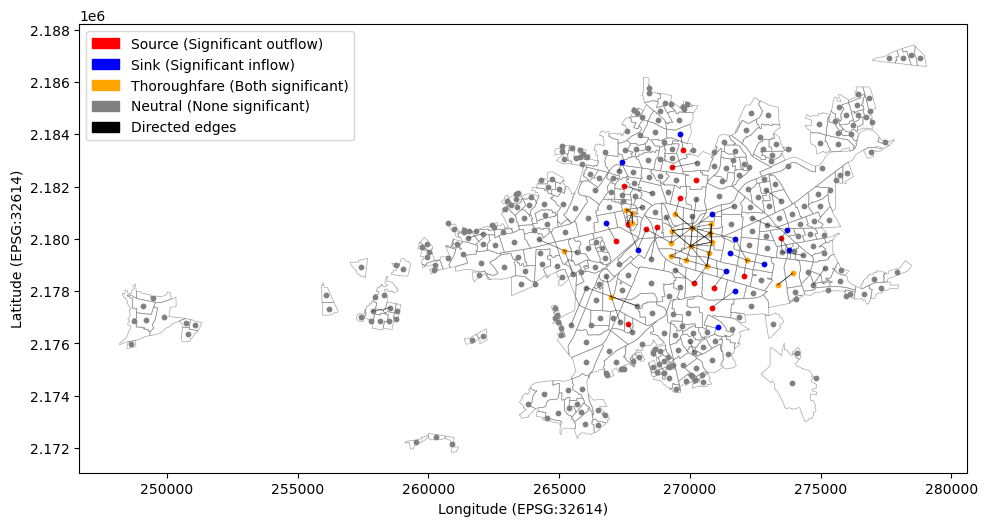


------------------------------------------------------------
ANALYSIS SUCCESSFULLY COMPLETED
------------------------------------------------------------



In [20]:
G_final_com, matriz_adyacencia_obs_com, significancia_sim_com, p_valores_sim_com, significativos_inflow_outflow_com, p_valores_inflow_outflow_com, agebs_nombres = main(delta_t, delta_s, gdf_comercios, 99, gdf_agebs, crimen = "commercial robbery")

In [21]:
guardar_resultados_txt(matriz_adyacencia_obs_com, significancia_sim_com, p_valores_sim_com, significativos_inflow_outflow_com, p_valores_inflow_outflow_com, agebs_nombres, carpeta="CommercialRobbery", crimen_id = "CommercialRobbery_Gen")

All files have been successfully saved in the folder 'CommercialRobbery'.


## Daytime commercial robbery

In [22]:
gdf_robocomercios_dia, gdf_robocomercios_noche = dia_noche_separacion(gdf_comercios, hora_dia_inicio, hora_dia_fin)

In [23]:
gdf_robocomercios_dia

,CarpetaID,FechaInicio,FechaComision,Fiscalia,Municipio,Colonia,CalleNumero,Lugar,Latitud,Longitud,Delito,Arma,Violencia,geometry
14,71346,2017-01-16 17:55:00,2017-01-03 07:00:00,Morelia,Morelia,Cuauhtémoc,ANA MARIA GALLAGA NUMERO 643,Comercio,19.696891,-101.186051,Robo a comercios,Otro Elemento,SI,POINT (270849.866 2179413.716)
0,70574,2017-01-03 17:08:00,2017-01-03 17:00:00,Morelia,Morelia,Centenario,MIGUEL HIDALGO Y CASTILLO NUM. 1454,Restaurante,19.733021,-101.173279,Robo a comercios,NaN,NO,POINT (272240.387 2183396.791)
2,70310,2017-01-04 15:25:00,2017-01-04 08:30:00,Morelia,Morelia,Centro Histórico,REVOLUCION NUM. 216,Comercio,19.704821,-101.184099,Robo a comercios,NaN,SI,POINT (271065.848 2180289.085)
1,70042,2017-01-04 13:36:00,2017-01-04 12:00:00,Morelia,Morelia,Quinceo,PERIFERICO PASEO DE LA REPUBLICA ESQUINA AV. Q...,Comercio,19.724571,-101.223847,Robo a comercios,NaN,SI,POINT (266926.552 2182529.916)
3,70261,2017-01-04 17:37:00,2017-01-04 12:40:00,Morelia,Morelia,Francisco J. Múgica,PLAN SEXENAL NUM. 200,Negocio de computadoras,19.725093,-101.189609,Robo a comercios,Arma de Fuego,NO,POINT (270517.029 2182541.026)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,305189,2021-06-14 18:23:00,2021-06-14 13:56:00,Morelia,Morelia,Solidaridad,Benito Juárez,Inmueble,19.731514,-101.204625,Robo a comercios,Otro Elemento,SI,POINT (268951.917 2183272.325)
2243,305162,2021-06-18 12:09:00,2021-06-17 11:25:00,Morelia,Morelia,Centro Histórico,abasolo 713,Comercio,19.696613,-101.194172,Robo a comercios,Desconocida,NO,POINT (269997.903 2179393.924)
2242,305083,2021-06-18 00:18:00,2021-06-17 13:30:00,Morelia,Morelia,Isaac Arriaga,COAHUILA,Farmacia,19.708825,-101.172172,Robo a comercios,Arma de Fuego,NO,POINT (272322.208 2180716.339)
2253,306352,2021-06-28 12:40:00,2021-06-25 10:30:00,Morelia,Morelia,Fuentes de Morelia,AVENIDA FUENTES DE MORELIA #337-A,Comercio,19.671394,-101.203746,Robo a comercios,Desconocida,NO,POINT (268957.677 2176614.675)



------------------------------------------------------------
STARTING CRIMINAL NETWORK ANALYSIS
------------------------------------------------------------

[1] Creation of observed directed network
Number of connected nodes: 292
Number of edges: 188
Directed network of observed data successfully created.

[2] Calculating transition matrix
Transition matrix of observed data successfully created.

[3] Monte Carlo simulations
Simulations successfully created.

[4] Calculating spatial significance
Simulation significance successfully calculated.
Significant crime pairs: 83

[5] Creation and visualization of significant network
Graph and visualization successfully generated.


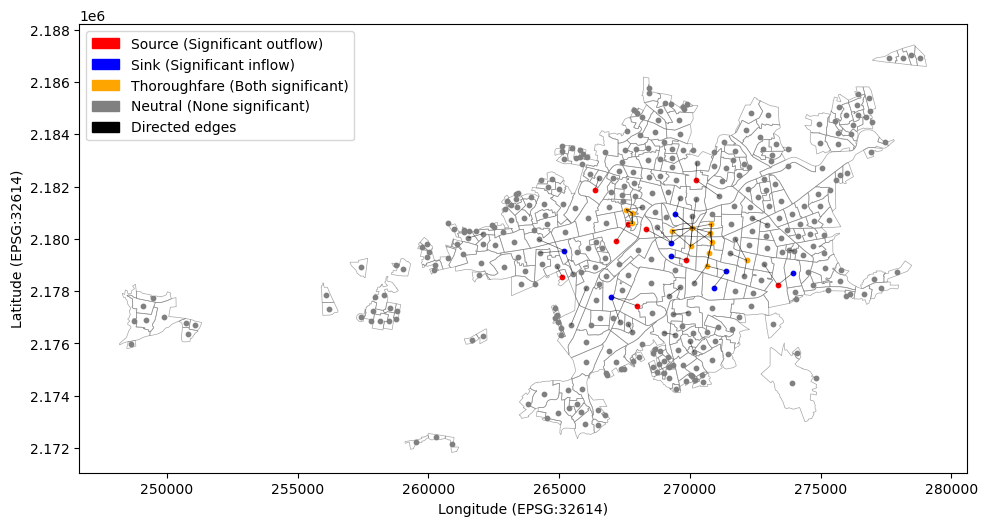


------------------------------------------------------------
ANALYSIS SUCCESSFULLY COMPLETED
------------------------------------------------------------



In [24]:
G_final_com_dia, matriz_adyacencia_obs_com_dia, significancia_sim_com_dia, p_valores_sim_com_dia, significativos_inflow_outflow_com_dia, p_valores_inflow_outflow_com_dia, agebs_nombres = main(delta_t, delta_s, gdf_robocomercios_dia, 99, gdf_agebs, crimen = "daytime commercial robbery")

In [25]:
guardar_resultados_txt(matriz_adyacencia_obs_com_dia, significancia_sim_com_dia, p_valores_sim_com_dia, significativos_inflow_outflow_com_dia, p_valores_inflow_outflow_com_dia, agebs_nombres, carpeta="CommercialRobbery", crimen_id = "CommercialRobbery_Day")

All files have been successfully saved in the folder 'CommercialRobbery'.


## Nighttime commercial robbery

In [26]:
gdf_robocomercios_noche

,CarpetaID,FechaInicio,FechaComision,Fiscalia,Municipio,Colonia,CalleNumero,Lugar,Latitud,Longitud,Delito,Arma,Violencia,geometry
6,70662,2017-01-08 14:18:00,2017-01-06 01:00:00,Morelia,Morelia,Centro Histórico,EDUARDO RUIZ NUMERO 294,Comercio,19.705662,-101.194144,Robo a comercios,NaN,NO,POINT (270013.748 2180395.776)
34,73433,2017-01-29 17:33:00,2017-01-11 19:20:00,Morelia,Morelia,Primo Tapia,Luis Mora Tovar número 305,Abarrotes,19.718093,-101.164396,Robo a comercios,Arma de Fuego,SI,POINT (273150.587 2181732.085)
11,71190,2017-01-13 19:01:00,2017-01-12 22:00:00,Morelia,Morelia,N/E,carretera de Azimbo y la noria s/n,Bar,19.705950,-101.194982,Robo a comercios,NaN,NO,POINT (269926.289 2180428.798)
18,72228,2017-01-19 06:22:00,2017-01-19 06:20:00,Morelia,Morelia,San Juanito Itzicuaro,AV. FRANCISCO I. MADERO PONIENTE,Comercio,19.697714,-101.250763,Robo a comercios,NaN,SI,POINT (264065.040 2179593.443)
28,73027,2017-01-25 17:18:00,2017-01-24 20:30:00,Morelia,Morelia,Cinco de Mayo,AVENIDA TATA VASCO NUMERO 418,Comercio,19.703084,-101.177458,Robo a comercios,Arma de Fuego,SI,POINT (271759.744 2180087.825)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252,306495,2021-06-28 11:23:00,2021-06-23 21:00:00,Morelia,Morelia,Centro Histórico,Vasco de Quiroga 43,Comercio,19.698423,-101.189830,Robo a comercios,Arma de Fuego,SI,POINT (270455.794 2179588.430)
2247,306461,2021-06-24 18:19:00,2021-06-23 22:30:00,Morelia,Morelia,Chapultepec Sur,ARTILLEROS DE 1847 # 771,Restaurante,19.691649,-101.169208,Robo a comercios,Arma de Fuego,SI,POINT (272608.706 2178810.707)
2246,306188,2021-06-24 03:17:00,2021-06-24 02:36:00,Morelia,Morelia,Camelinas,DOCTOR IGNACIO CHÁVEZ ESQUINA CON SOLIDARIDAD,Comercio,19.715656,-101.175185,Robo a comercios,Arma de Fuego,SI,POINT (272015.887 2181476.747)
2249,306099,2021-06-25 11:51:00,2021-06-24 22:00:00,Morelia,Morelia,Cinco de Mayo,avenida tata vasco numero 418,Comercio,19.704348,-101.177636,Robo a comercios,Desconocida,SI,POINT (271742.893 2180227.968)



------------------------------------------------------------
STARTING CRIMINAL NETWORK ANALYSIS
------------------------------------------------------------

[1] Creation of observed directed network
Number of connected nodes: 92
Number of edges: 51
Directed network of observed data successfully created.

[2] Calculating transition matrix
Transition matrix of observed data successfully created.

[3] Monte Carlo simulations
Simulations successfully created.

[4] Calculating spatial significance
Simulation significance successfully calculated.
Significant crime pairs: 41

[5] Creation and visualization of significant network
Graph and visualization successfully generated.


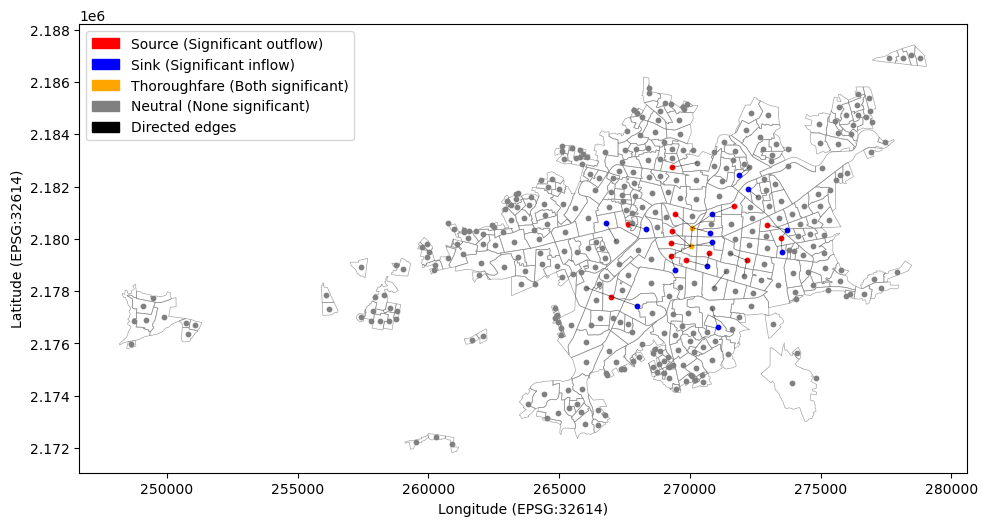


------------------------------------------------------------
ANALYSIS SUCCESSFULLY COMPLETED
------------------------------------------------------------



In [27]:
G_final_com_noche, matriz_adyacencia_obs_com_noche, significancia_sim_com_noche, p_valores_sim_com_noche, significativos_inflow_outflow_com_noche, p_valores_inflow_outflow_com_noche, agebs_nombres = main(delta_t, delta_s, gdf_robocomercios_noche, 99, gdf_agebs, crimen = "nighttime commercial robbery")

In [28]:
guardar_resultados_txt(matriz_adyacencia_obs_com_noche, significancia_sim_com_noche, p_valores_sim_com_noche, significativos_inflow_outflow_com_noche, p_valores_inflow_outflow_com_noche, agebs_nombres, carpeta="CommercialRobbery", crimen_id = "CommercialRobbery_Night")

All files have been successfully saved in the folder 'CommercialRobbery'.


# Vehicle theft

## General

In [29]:
gdf_vehiculos = gpd.read_file("RoboVehiculos2017-2024.geojson")
gdf_vehiculos

,CarpetaID,FechaInicio,FechaComision,Fiscalia,Municipio,Colonia,CalleNumero,Lugar,Latitud,Longitud,Delito,Arma,Violencia,geometry
0,70688,2017-01-02 03:19:00,2017-01-02 01:30:00,Morelia,Morelia,N/E,la Mina Número 115,Calle,19.781302,-101.108132,Robo de vehículo,Arma Blanca,NO,POINT (279136.739 2188656.033)
1,70696,2017-01-02 10:55:00,2017-01-01 18:00:00,Morelia,Morelia,Lomas de Hidalgo,30 de julio número 257,Fuera del domicilio,19.698036,-101.161685,Robo de vehículo,NaN,NO,POINT (273406.564 2179507.798)
2,70735,2017-01-02 22:34:00,2017-01-02 21:10:00,Morelia,Morelia,Trincheras de Morelos,CENOVIO PANIAGUA,Estacionamiento,19.666850,-101.186549,Robo de vehículo,Arma de Fuego,NO,POINT (270754.873 2176088.285)
3,70739,2017-01-03 00:31:00,2017-01-02 18:00:00,Morelia,Morelia,Centro Histórico,allende esquina con QUINTANA ROO,Calle,19.701939,-101.196844,Robo de vehículo,NaN,NO,POINT (269725.300 2179987.226)
4,70747,2017-01-03 10:10:00,2017-01-02 17:00:00,Morelia,Morelia,N/E,N/E,Calle,19.673596,-101.391520,Robo de vehículo,NaN,NO,POINT (249266.222 2177124.502)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9278,469880,2024-08-29 23:00:00,2024-08-29 00:20:00,Morelia,Morelia,Josefa Ortiz de Domínguez,PERIFERICO PASEO DE LA REPUBLICA,Calle,19.702685,-101.157013,Robo de vehículo,Otro Elemento,NO,POINT (273902.990 2180016.286)
9279,470060,2024-08-30 14:24:00,2024-08-28 13:00:00,Morelia,Morelia,Isaac Arriaga,2 DE MAYO,Calle,19.710743,-101.171646,Robo de vehículo,Otro Elemento,NO,POINT (272380.058 2180928.036)
9280,469991,2024-08-30 14:43:00,2024-08-29 04:20:00,Morelia,Morelia,Camponubes,paseo campo nubes,Calle,19.700155,-101.289569,Robo de vehículo,Otro Elemento,NO,POINT (259999.237 2179918.098)
9281,470136,2024-08-31 11:18:00,2024-08-30 20:50:00,Morelia,Morelia,Villa Universidad,ALBERTO ALVARADO,Calle,19.688130,-101.199151,Robo de vehículo,Arma de Fuego,SI,POINT (269463.610 2178461.440)



------------------------------------------------------------
STARTING CRIMINAL NETWORK ANALYSIS
------------------------------------------------------------

[1] Creation of observed directed network
Number of connected nodes: 4171
Number of edges: 4248
Directed network of observed data successfully created.

[2] Calculating transition matrix
Transition matrix of observed data successfully created.

[3] Monte Carlo simulations
Simulations successfully created.

[4] Calculating spatial significance
Simulation significance successfully calculated.
Significant crime pairs: 338

[5] Creation and visualization of significant network
Graph and visualization successfully generated.


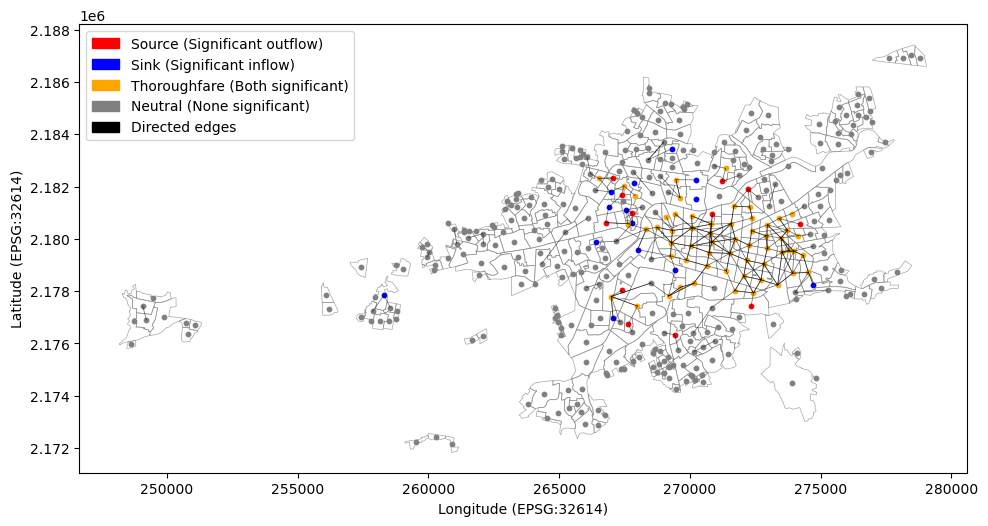


------------------------------------------------------------
ANALYSIS SUCCESSFULLY COMPLETED
------------------------------------------------------------



In [30]:
G_final_veh, matriz_adyacencia_obs_veh, significancia_sim_veh, p_valores_sim_veh, significativos_inflow_outflow_veh, p_valores_inflow_outflow_veh, agebs_nombres = main(delta_t, delta_s, gdf_vehiculos, 99, gdf_agebs, crimen = "vehicle theft")

In [31]:
guardar_resultados_txt(matriz_adyacencia_obs_veh, significancia_sim_veh, p_valores_sim_veh, significativos_inflow_outflow_veh, p_valores_inflow_outflow_veh, agebs_nombres, carpeta="VehicleTheft", crimen_id = "VehicleTheft_Gen")

All files have been successfully saved in the folder 'VehicleTheft'.


## Daytime vehicle theft

In [32]:
gdf_robovehiculos_dia, gdf_robovehiculos_noche = dia_noche_separacion(gdf_vehiculos, hora_dia_inicio, hora_dia_fin)

In [33]:
gdf_robovehiculos_dia

,CarpetaID,FechaInicio,FechaComision,Fiscalia,Municipio,Colonia,CalleNumero,Lugar,Latitud,Longitud,Delito,Arma,Violencia,geometry
1,70696,2017-01-02 10:55:00,2017-01-01 18:00:00,Morelia,Morelia,Lomas de Hidalgo,30 de julio número 257,Fuera del domicilio,19.698036,-101.161685,Robo de vehículo,NaN,NO,POINT (273406.564 2179507.798)
4,70747,2017-01-03 10:10:00,2017-01-02 17:00:00,Morelia,Morelia,N/E,N/E,Calle,19.673596,-101.391520,Robo de vehículo,NaN,NO,POINT (249266.222 2177124.502)
3,70739,2017-01-03 00:31:00,2017-01-02 18:00:00,Morelia,Morelia,Centro Histórico,allende esquina con QUINTANA ROO,Calle,19.701939,-101.196844,Robo de vehículo,NaN,NO,POINT (269725.300 2179987.226)
5,70843,2017-01-03 15:27:00,2017-01-03 08:35:00,Morelia,Morelia,Chapultepec Norte,Avenida Lázaro Cárdenas,Calle,19.693087,-101.176267,Robo de vehículo,NaN,NO,POINT (271870.453 2178979.373)
7,70854,2017-01-03 22:37:00,2017-01-03 16:00:00,Morelia,Morelia,Nueva Chapultepec,Aristeo Mercado esquina del boulevard Agustin ...,Calle,19.687689,-101.172714,Robo de vehículo,NaN,NO,POINT (272235.399 2178376.949)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9276,469793,2024-08-29 14:12:00,2024-08-27 15:15:00,Morelia,Morelia,Ventura Puente,VICENTE SANTA MARIA,Calle,19.692289,-101.187899,Robo de vehículo,Otro Elemento,NO,POINT (270649.487 2178906.726)
9272,469700,2024-08-28 12:58:00,2024-08-28 08:30:00,Morelia,Morelia,Matamoros,AVENIDA ACUEDUCTO,Estacionamiento,19.696133,-101.165727,Robo de vehículo,Otro Elemento,NO,POINT (272980.060 2179302.544)
9273,469737,2024-08-28 14:27:00,2024-08-28 10:30:00,Morelia,Morelia,Atapaneo,BOSQUE DE LOS OLIVOS,Calle,19.733631,-101.105887,Robo de vehículo,Otro Elemento,NO,POINT (279306.426 2183375.210)
9279,470060,2024-08-30 14:24:00,2024-08-28 13:00:00,Morelia,Morelia,Isaac Arriaga,2 DE MAYO,Calle,19.710743,-101.171646,Robo de vehículo,Otro Elemento,NO,POINT (272380.058 2180928.036)



------------------------------------------------------------
STARTING CRIMINAL NETWORK ANALYSIS
------------------------------------------------------------

[1] Creation of observed directed network
Number of connected nodes: 1855
Number of edges: 1770
Directed network of observed data successfully created.

[2] Calculating transition matrix
Transition matrix of observed data successfully created.

[3] Monte Carlo simulations
Simulations successfully created.

[4] Calculating spatial significance
Simulation significance successfully calculated.
Significant crime pairs: 181

[5] Creation and visualization of significant network
Graph and visualization successfully generated.


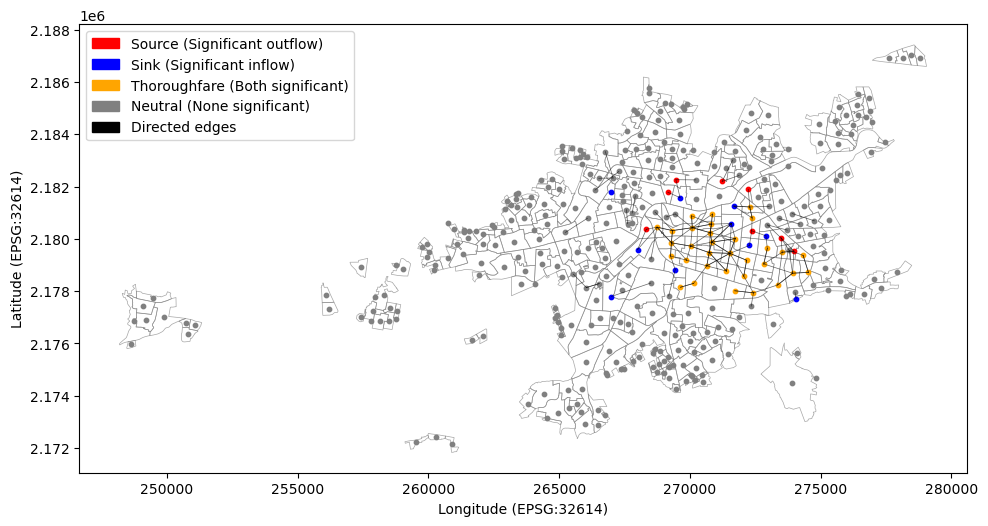


------------------------------------------------------------
ANALYSIS SUCCESSFULLY COMPLETED
------------------------------------------------------------



In [34]:
G_final_veh_dia, matriz_adyacencia_obs_veh_dia, significancia_sim_veh_dia, p_valores_sim_veh_dia, significativos_inflow_outflow_veh_dia, p_valores_inflow_outflow_veh_dia, agebs_nombres = main(delta_t, delta_s, gdf_robovehiculos_dia, 99, gdf_agebs, crimen = "daytime vehicle theft")

In [35]:
guardar_resultados_txt(matriz_adyacencia_obs_veh_dia, significancia_sim_veh_dia, p_valores_sim_veh_dia, significativos_inflow_outflow_veh_dia, p_valores_inflow_outflow_veh_dia, agebs_nombres, carpeta = "VehicleTheft", crimen_id = "VehicleThefts_Day")

All files have been successfully saved in the folder 'VehicleTheft'.


## Nighttime vehicle theft

In [36]:
gdf_robovehiculos_noche

,CarpetaID,FechaInicio,FechaComision,Fiscalia,Municipio,Colonia,CalleNumero,Lugar,Latitud,Longitud,Delito,Arma,Violencia,geometry
34,70206,2017-01-07 12:34:00,2017-01-01 20:00:00,Morelia,Morelia,Las Flores,CLAVEL,Calle,19.705301,-101.205641,Robo de vehículo,Arma de Fuego,NO,POINT (268807.672 2180371.421)
0,70688,2017-01-02 03:19:00,2017-01-02 01:30:00,Morelia,Morelia,N/E,la Mina Número 115,Calle,19.781302,-101.108132,Robo de vehículo,Arma Blanca,NO,POINT (279136.739 2188656.033)
93,71593,2017-01-17 12:39:00,2017-01-02 19:00:00,Morelia,Morelia,Lomas del Valle,"loma bella, numeral 21",Fuera del domicilio,19.690118,-101.230346,Robo de vehículo,NaN,NO,POINT (266195.047 2178724.168)
6,70852,2017-01-03 17:55:00,2017-01-02 19:00:00,Morelia,Morelia,Trincheras de Morelos,Senobio Paniagua frente al número 50,Calle,19.665491,-101.190475,Robo de vehículo,NaN,NO,POINT (270341.165 2175943.114)
2,70735,2017-01-02 22:34:00,2017-01-02 21:10:00,Morelia,Morelia,Trincheras de Morelos,CENOVIO PANIAGUA,Estacionamiento,19.666850,-101.186549,Robo de vehículo,Arma de Fuego,NO,POINT (270754.873 2176088.285)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9275,469813,2024-08-29 13:51:00,2024-08-28 20:00:00,Morelia,Morelia,Chiquimitío,carretera Morelia - Copándaro de Galeana,Carretera,19.793023,-101.250183,Robo de vehículo,Otro Elemento,NO,POINT (264265.984 2190145.585)
9278,469880,2024-08-29 23:00:00,2024-08-29 00:20:00,Morelia,Morelia,Josefa Ortiz de Domínguez,PERIFERICO PASEO DE LA REPUBLICA,Calle,19.702685,-101.157013,Robo de vehículo,Otro Elemento,NO,POINT (273902.990 2180016.286)
9280,469991,2024-08-30 14:43:00,2024-08-29 04:20:00,Morelia,Morelia,Camponubes,paseo campo nubes,Calle,19.700155,-101.289569,Robo de vehículo,Otro Elemento,NO,POINT (259999.237 2179918.098)
9281,470136,2024-08-31 11:18:00,2024-08-30 20:50:00,Morelia,Morelia,Villa Universidad,ALBERTO ALVARADO,Calle,19.688130,-101.199151,Robo de vehículo,Arma de Fuego,SI,POINT (269463.610 2178461.440)



------------------------------------------------------------
STARTING CRIMINAL NETWORK ANALYSIS
------------------------------------------------------------

[1] Creation of observed directed network
Number of connected nodes: 1023
Number of edges: 691
Directed network of observed data successfully created.

[2] Calculating transition matrix
Transition matrix of observed data successfully created.

[3] Monte Carlo simulations
Simulations successfully created.

[4] Calculating spatial significance
Simulation significance successfully calculated.
Significant crime pairs: 170

[5] Creation and visualization of significant network
Graph and visualization successfully generated.


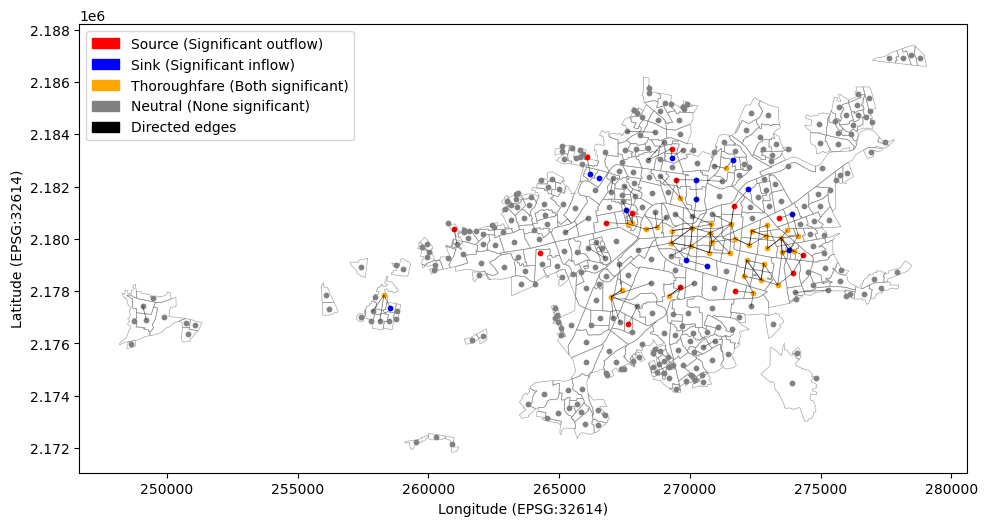


------------------------------------------------------------
ANALYSIS SUCCESSFULLY COMPLETED
------------------------------------------------------------



In [37]:
G_final_veh_noche, matriz_adyacencia_obs_veh_noche, significancia_sim_veh_noche, p_valores_sim_veh_noche, significativos_inflow_outflow_veh_noche, p_valores_inflow_outflow_veh_noche, agebs_nombres = main(delta_t, delta_s, gdf_robovehiculos_noche, 99, gdf_agebs, crimen = "nighttime vehicle theft")

In [38]:
guardar_resultados_txt(matriz_adyacencia_obs_veh_noche, significancia_sim_veh_noche, p_valores_sim_veh_noche, significativos_inflow_outflow_veh_noche, p_valores_inflow_outflow_veh_noche, agebs_nombres, carpeta = "VehicleTheft", crimen_id = "VehicleTheft_Night")

All files have been successfully saved in the folder 'VehicleTheft'.
